In [5]:
%load_ext autoreload
%autoreload 2
import dask_image.imread as imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
from palm_tools.tif_tools.localization import localize_movie
import dask.array as da

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
mov = imread.imread("/Users/hverdier/Desktop/exemples_mifobio/ROI_1_bien.tif",nframes=1000)
mov = mov[:1000]

In [70]:
dfs = {}
for sliding_filter in [True,False]:
    for subpixel_mode in ["phaser","radial"]:
        dfs[(sliding_filter,subpixel_mode)] = localize_movie(mov,factor=1.,filter_size=3,sliding_filter=sliding_filter,num_processes=3,verbose=True, subpixel_mode=subpixel_mode)

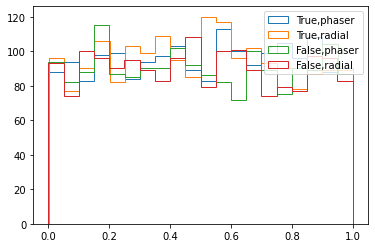

In [110]:
for key, df in dfs.items():
    plt.hist(df.x-df.x.astype(int),bins=20,label=("%s,%s") % key,histtype="step")
plt.legend()

(40.0, 60.0)

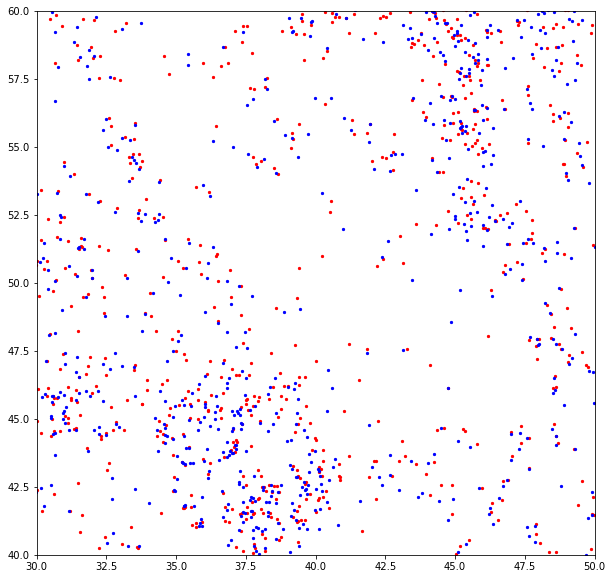

In [90]:
plt.figure(figsize=(10,10))
for key, df in dfs.items():
    w, sub = key
    plt.scatter(df.x,df.y,s=5,c="red" if w else "blue")
plt.xlim((30,50))
plt.ylim((40,60))

In [71]:
mov_arr = np.array(mov)

In [72]:
thresh = np.std(mov_arr,axis=(1,2)).reshape((-1,1,1))

In [63]:
res_1 = peak_local_max(mov_arr,
    threshold_abs=thresh,
    min_distance=5,
    footprint=np.stack([np.zeros((3,3)),np.ones((3,3)),np.zeros((3,3))],axis=0))

In [57]:
res_2 = []
for i in range(mov_arr.shape[0]):
    res_2.append(peak_local_max(mov_arr[i], threshold_abs=thresh[i],min_distance=5, footprint=np.ones((3,3))))
res_2 = np.concatenate(res_2,axis=0)

(40.0, 60.0)

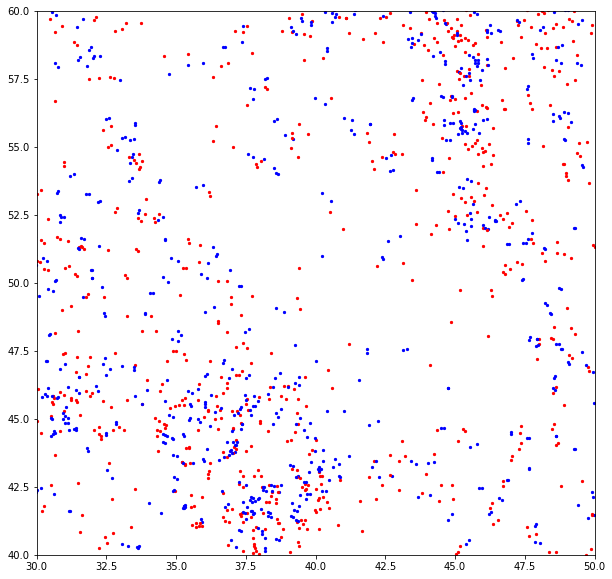

In [91]:
plt.figure(figsize=(10,10))
for key, df in dfs.items():
    w, sub = key
    plt.scatter(df.x,df.y,s=5,c="red" if sub == "phaser" else "blue")
plt.xlim((30,50))
plt.ylim((40,60))

Blue dots are closer one from the other than red dots 
-> __The phasing method is more stable (re. percentile filtering)__

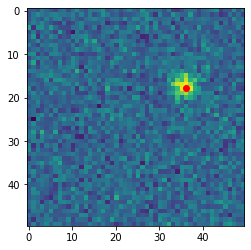

In [11]:
xx = np.arange(50)
yy = np.arange(50)
XX, YY = np.meshgrid(xx,yy)
sigma = 2.5
n_tests = 100
errors = {}

for mode in ["phaser","radial"]:
    for sigma in [2.,3.]:
        for noise in [2,3]:
            errors[(mode, sigma, noise)] = np.zeros((n_tests,2))
            for i in range(n_tests):
                pos = np.random.uniform(10,40,size=(1,2))

                D_2 = (XX-pos[0,0])**2 + (YY - pos[0,1])**2

                I = np.exp(-D_2/(2*(sigma**2))).reshape((1,50,50))
                I += np.std(I)*2*np.random.normal(size=I.shape)
                pos_fit = localize_movie(da.array(I),factor=1.,subpixel_mode=mode, progress_bar=False);
                
                errors[(mode, sigma, noise)][i] = pos_fit[["y","x"]].values[0] - pos
                if np.random.uniform(0,1) < .001:
                    plt.figure()
                    plt.imshow(I[0])
                    plt.scatter(pos_fit.y,pos_fit.x,c="red")


In [12]:
pos_fit

frame          x          y     ratio     sigma  total_intensity
0      0  18.216575  14.693231  1.695926  3.924596        50.871594

In [8]:
for key, value in errors.items():
    print(key)
    print(np.std(value))

('phaser', 2.0, 2)
0.474273968582631
('phaser', 2.0, 3)
0.789264494165314
('phaser', 3.0, 2)
0.9127392223494244
('phaser', 3.0, 3)
0.8805111717475832
('radial', 2.0, 2)
0.12835726360886954
('radial', 2.0, 3)
0.1229997185425885
('radial', 3.0, 2)
0.6653422666737704
('radial', 3.0, 3)
0.3007560606272736


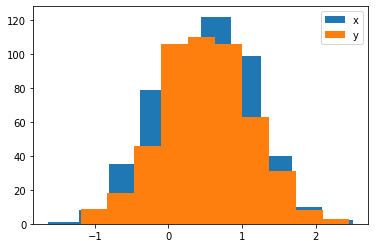

In [73]:
plt.hist(error[:,0],label="x")
plt.hist(error[:,1],label="y")
plt.legend()

(array([2., 7., 2., 6., 2., 3., 1., 3., 3., 1.]),
 array([-0.0578986,  0.09344  ,  0.2447786,  0.3961172,  0.5474558,
         0.6987944,  0.850133 ,  1.0014716,  1.1528102,  1.3041488,
         1.4554874]),
 <BarContainer object of 10 artists>)

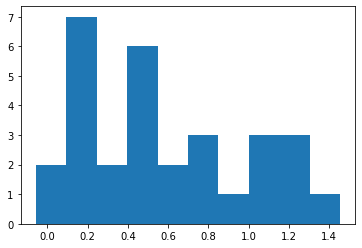

In [49]:
plt.hist(error[:,0])

100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


frame         x          y     sigma  total_intensity
0      0  26.85042  27.343714  3.824649        59.444805